# **📘 Fake News Detection using Spark + LSTM (Colab version)**

Basad on paper: Real-Time Fake News Detection Using Big Data Analytics and Deep Neural Network (IEEE, 2023)

# Real-Time Fake News Detection — Colab + PySpark (Notebook)

**Purpose:** Replicate (in smaller scale) the experiment conducted in the paper *"Real-Time Fake News Detection Using Big Data Analytics and Deep Neural Network"*.
This notebook runs in **Google Colab**, uses **PySpark** for pre-processing e demonstrates **parallel training** of models (through Spark RDD), saving weights/results in a Google Drive folder.

**Steps Overview:**
1. Setup (Java, PySpark)
2. Mount Drive e paths
3. Load and Clean datasets (Fake/True + LIAR)
4. Pre-processing in Spark (tokenize, HashingTF, IDF)
5. Create sequences for LSTM (Keras Tokenizer)
6. Parallel training with Spark RDD (each executor trains a model and save the weights)
7. Ensemble e driver evaluation (can be done in GPU)

In [1]:
# 1) SETUP: install Java and PySpark
!apt-get update -qq
!apt-get install -y openjdk-11-jdk-headless -qq > /dev/null
!pip install -q pyspark==3.5.1 numpy pandas scikit-learn tensorflow==2.19.0 joblib tqdm

import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'
print('JAVA_HOME set to', os.environ['JAVA_HOME'])

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
JAVA_HOME set to /usr/lib/jvm/java-11-openjdk-amd64


In [2]:
# 2) Mount Google Drive and define paths (you must edit DATA_DIR and OUTPUT_DIR to the desired path in your drive)
from google.colab import drive
drive.mount('/content/drive')

# --- EDIT this paths for your drive structure:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/BDP - Project/Data'   # <-- folder with the dataset files
OUTPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/BDP - Project/Results'  # <-- where the arrays, weights and models will be saved

import os
os.makedirs(OUTPUT_DIR, exist_ok=True)
print('DATA_DIR =', DATA_DIR)
print('OUTPUT_DIR =', OUTPUT_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATA_DIR = /content/drive/MyDrive/Colab Notebooks/BDP - Project/Data
OUTPUT_DIR = /content/drive/MyDrive/Colab Notebooks/BDP - Project/Results


In [3]:
# 3) Imports and defining the cleaning function for the text
import re, time, pickle, json, os
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
tqdm.pandas()

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'http\\S+', '', text)
    text = re.sub(r'[^a-zA-Z\\s]', ' ', text)
    text = text.lower().strip()
    text = re.sub(r'\\s+', ' ', text)
    return text

In [4]:
# 4) Load datasets (Fake.csv, True.csv, LIAR) - adjust the paths if necessary

import os

fake_path = os.path.join(DATA_DIR,'fake-and-real-news-dataset', 'Fake.csv')
true_path = os.path.join(DATA_DIR,'fake-and-real-news-dataset', 'True.csv')
liar_train = os.path.join(DATA_DIR, 'LIAR-DATASET', 'train.tsv')
liar_test  = os.path.join(DATA_DIR, 'LIAR-DATASET', 'test.tsv')
liar_valid = os.path.join(DATA_DIR, 'LIAR-DATASET', 'valid.tsv')

print('Paths:')
print(fake_path, os.path.exists(fake_path))
print(true_path, os.path.exists(true_path))
print(liar_train, os.path.exists(liar_train))
print(liar_test, os.path.exists(liar_test))
print(liar_valid, os.path.exists(liar_valid))

# Load 'fake-and-real-news-dataset' - Kaggle
fake_df = pd.read_csv(fake_path)
true_df = pd.read_csv(true_path)
print('Fake shape', fake_df.shape, 'True shape', true_df.shape)

fake_df['label'] = 0
true_df['label'] = 1

# Load LIAR-DATASET
col_names = ["id","label","statement","subject","speaker","speaker_job_title","state_info","party_affiliation","barely_true_counts","false_counts","half_true_counts","mostly_true_counts","pants_on_fire_counts","context"]
liar_parts = []
for p in [liar_train, liar_test, liar_valid]:
    if os.path.exists(p):
        tmp = pd.read_csv(p, sep='\t', header=None, quoting=3, encoding='latin1', engine='python')
        tmp.columns = col_names[:tmp.shape[1]]
        liar_parts.append(tmp)
    else:
        print('LIAR file not found:', p)


liar_df = pd.concat(liar_parts, ignore_index=True) if liar_parts else pd.DataFrame(columns=col_names)
print('LIAR combined shape:', liar_df.shape)

# Mapping LIAR for binary: 1 = true, 0 = others
if not liar_df.empty:
    liar_df['label'] = liar_df['label'].apply(lambda x: 1 if str(x).lower()=='true' else 0)

# Prepare 'text' columns for all the dataframes
if 'text' not in fake_df.columns and 'title' in fake_df.columns:
    fake_df['text'] = fake_df['title'] + ' ' + fake_df.get('text','')
if 'text' not in true_df.columns and 'title' in true_df.columns:
    true_df['text'] = true_df['title'] + ' ' + true_df.get('text','')

fake_small = fake_df[['text','label']].copy()
true_small = true_df[['text','label']].copy()
liar_small = liar_df[['statement','label']].rename(columns={'statement':'text'}).copy() if not liar_df.empty else pd.DataFrame(columns=['text','label'])

all_df = pd.concat([fake_small, true_small, liar_small], ignore_index=True)
print('Combined dataset shape before cleaning:', all_df.shape)

# Cleaning
all_df['clean_text'] = all_df['text'].progress_apply(clean_text)
all_df = all_df[all_df['clean_text'].str.len() > 0].reset_index(drop=True)
print('Combined after cleaning:', all_df.shape)
print(all_df['label'].value_counts(normalize=True))

# Saving clean version for replication
cleaned_path = os.path.join(OUTPUT_DIR, 'combined_cleaned.csv')
all_df.to_csv(cleaned_path, index=False)
print('Saved cleaned dataset to', cleaned_path)

Paths:
/content/drive/MyDrive/Colab Notebooks/BDP - Project/Data/fake-and-real-news-dataset/Fake.csv True
/content/drive/MyDrive/Colab Notebooks/BDP - Project/Data/fake-and-real-news-dataset/True.csv True
/content/drive/MyDrive/Colab Notebooks/BDP - Project/Data/LIAR-DATASET/train.tsv True
/content/drive/MyDrive/Colab Notebooks/BDP - Project/Data/LIAR-DATASET/test.tsv True
/content/drive/MyDrive/Colab Notebooks/BDP - Project/Data/LIAR-DATASET/valid.tsv True
Fake shape (23481, 4) True shape (21417, 4)
LIAR combined shape: (12836, 14)
Combined dataset shape before cleaning: (57734, 2)


100%|██████████| 57734/57734 [00:12<00:00, 4781.93it/s] 


Combined after cleaning: (57103, 3)
label
0    0.588831
1    0.411169
Name: proportion, dtype: float64
Saved cleaned dataset to /content/drive/MyDrive/Colab Notebooks/BDP - Project/Results/combined_cleaned.csv


In [5]:
#Example for the original LIAR DATASET
col_names = ["id","label","statement","subject","speaker","speaker_job_title","state_info","party_affiliation","barely_true_counts","false_counts","half_true_counts","mostly_true_counts","pants_on_fire_counts","context"]
teste_liar = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BDP - Project/Data/LIAR-DATASET/test.tsv", sep='\t', header=None, quoting=3, encoding='latin1', engine='python')
teste_liar.columns = col_names[:teste_liar.shape[1]]
teste_liar.head()

,id,label,statement,subject,speaker,speaker_job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [6]:
#Example for the original Fake/true dataset
fake_df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [7]:
#Combined and cleaned dataset
all_df

,text,label,clean_text
0,Donald Trump just couldn t wish all Americans ...,0,donald trump just couldn t wish all americans ...
1,House Intelligence Committee Chairman Devin Nu...,0,house intelligence committee chairman devin nu...
2,"On Friday, it was revealed that former Milwauk...",0,on friday it was revealed that former milwauk...
3,"On Christmas day, Donald Trump announced that ...",0,on christmas day donald trump announced that ...
4,Pope Francis used his annual Christmas Day mes...,0,pope francis used his annual christmas day mes...
...,...,...,...
57098,"For the first time in more than a decade, impo...",0,for the first time in more than a decade impo...
57099,Says Donald Trump has bankrupted his companies...,0,says donald trump has bankrupted his companies...
57100,"John McCain and George Bush have ""absolutely n...",1,john mccain and george bush have absolutely n...
57101,"""A new poll shows 62 percent support the presi...",0,a new poll shows percent support the presid...


In [8]:
# 5) Spark preprocessing with N-grams + TF-IDF + timing
import time
start_time = time.time()

from pyspark.sql import SparkSession
from pyspark.ml.feature import (
    RegexTokenizer, StopWordsRemover, NGram,
    HashingTF, IDF
)
from pyspark.ml import Pipeline
from pyspark.sql.functions import concat, col

spark = SparkSession.builder \
    .appName('fake-news-preprocessing-ngram') \
    .master('local[*]') \
    .config('spark.driver.memory', '6g') \
    .config('spark.executor.memory', '6g') \
    .getOrCreate()

print("Spark version:", spark.version)

# Convert Pandas -> Spark
sdf = spark.createDataFrame(
    all_df[['clean_text', 'label']].rename(columns={'clean_text': 'text'})
)

print(f"Input size: {sdf.count():,} rows")

# --- Pipeline with n-grams ---
tokenizer = RegexTokenizer(inputCol='text', outputCol='tokens', pattern='\\W')
remover = StopWordsRemover(inputCol='tokens', outputCol='filtered')
ngram2 = NGram(n=2, inputCol='filtered', outputCol='bigrams')

def merge_columns(df):
    return df.withColumn("tokens_final", concat(col("filtered"), col("bigrams")))

hashTF = HashingTF(
    inputCol='tokens_final',
    outputCol='rawFeatures',
    numFeatures=8000
)
idf = IDF(inputCol='rawFeatures', outputCol='tfidf_features')

# Run tokenizer + bigram creation
pipeline_initial = Pipeline(stages=[tokenizer, remover, ngram2])
model_initial = pipeline_initial.fit(sdf)
sdf_ng = model_initial.transform(sdf)

sdf_ng = merge_columns(sdf_ng)

# TF-IDF
pipeline_tfidf = Pipeline(stages=[hashTF, idf])
model_tfidf = pipeline_tfidf.fit(sdf_ng)
sdf_feat = model_tfidf.transform(sdf_ng)

# Limit memory (50% sample)
sdf_sample = sdf_feat.sample(fraction=0.20, seed=42)

pdf = sdf_feat.select("tfidf_features", "label").toPandas()

import numpy as np

X_tfidf = np.vstack(pdf['tfidf_features'].apply(lambda v: v.toArray()).values)
y = pdf['label'].values

np.save(os.path.join(OUTPUT_DIR, 'X_tfidf.npy'), X_tfidf)
np.save(os.path.join(OUTPUT_DIR, 'y_labels.npy'), y)

end_time = time.time()
print(f"Total preprocessing time: {end_time - start_time:.2f} seconds")



Spark version: 3.5.1
Input size: 57,103 rows
Total preprocessing time: 595.41 seconds


In [9]:
# 6) Create Keras tokenizer and sequences for LSTM; Saving the Arrays and tokenizer on Drive
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
tqdm.pandas() # Ensure tqdm is enabled for pandas operations, though not directly used here.

texts = all_df['clean_text'].tolist()
labels = all_df['label'].values

NUM_WORDS = 10000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token='<OOV>')
print("Fitting tokenizer on texts...")
tokenizer.fit_on_texts(tqdm(texts, desc="Tokenizer fitting"))
print("Converting texts to sequences...")
sequences = tokenizer.texts_to_sequences(tqdm(texts, desc="Text to sequences"))
X_seq = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
y_seq = labels

print('Sequences shape', X_seq.shape)

np.save(os.path.join(OUTPUT_DIR,'X_seq.npy'), X_seq)
np.save(os.path.join(OUTPUT_DIR,'y_seq.npy'), y_seq)
with open(os.path.join(OUTPUT_DIR,'tokenizer.pkl'), 'wb') as f:
    pickle.dump(tokenizer, f)
print('Saved sequence arrays and tokenizer to Drive')

Fitting tokenizer on texts...


Tokenizer fitting: 100%|██████████| 57103/57103 [00:23<00:00, 2440.06it/s] 


Converting texts to sequences...


Text to sequences: 100%|██████████| 57103/57103 [00:12<00:00, 4544.46it/s] 


Sequences shape (57103, 200)
Saved sequence arrays and tokenizer to Drive


In [10]:
# 7) Parallel training with Spark RDD (otimized version for Colab)
# ------------------------------------------------------------------
# Each Spark executor trains a LSTM model with different paramethers and saves its weights to Google Drive
# This version reduces the use of RAM and avoid lockup during training

from pyspark import SparkContext
import os, json

sc = spark.sparkContext

# Path to the arrays saved previously (adjust if needed)
X_seq_path = os.path.join(OUTPUT_DIR, 'X_seq.npy')
y_seq_path = os.path.join(OUTPUT_DIR, 'y_seq.npy')

# Configuration of the models to be trained in parallel (epochs can be adjusted)
configs = [
    {'name': 'lstm_64',  'units': 64,  'drop': 0.3, 'epochs': 2, 'batch_size': 128},
    {'name': 'lstm_128', 'units': 128, 'drop': 0.4, 'epochs': 2, 'batch_size': 128},
    {'name': 'lstm_256', 'units': 256, 'drop': 0.5, 'epochs': 1, 'batch_size': 128}
]

# Saving configs to Drive (only for rastreability)
with open(os.path.join(OUTPUT_DIR, 'configs.json'), 'w') as f:
    json.dump(configs, f)

print(f"⚙️ Initiating paralell training of {len(configs)} models...\n")

def train_lstm_worker(cfg):
    """ Function executed for each Spark executor (runs in CPU on Colab)."""
    import numpy as np, os, tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score

    try:
        # Load data
        X = np.load(os.path.join(OUTPUT_DIR, 'X_seq.npy'), mmap_mode='r')
        y = np.load(os.path.join(OUTPUT_DIR, 'y_seq.npy'), mmap_mode='r')

        # Using only a fraction of the data to save memory
        if len(X) > 50000:
            idx = np.random.choice(len(X), size=40000, replace=False)
            X, y = X[idx], y[idx]

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        model = Sequential()
        model.add(Embedding(input_dim=10000, output_dim=128, input_length=X.shape[1]))
        model.add(LSTM(cfg['units']))
        model.add(Dropout(cfg['drop']))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        print(f"🚀 [Worker] Training {cfg['name']} model with {cfg['units']} units...")

        model.fit(
            X_train, y_train,
            epochs=cfg['epochs'],
            batch_size=cfg['batch_size'],
            verbose=0
        )

        preds = (model.predict(X_val, batch_size=512, verbose=0) > 0.5).astype(int).flatten()
        acc = float(accuracy_score(y_val, preds))

        # Save weights to Drive
        weights_path = os.path.join(OUTPUT_DIR, cfg['name'] + '.weights.h5')
        model.save_weights(weights_path)
        tf.keras.backend.clear_session()  # Free RAM in the executor

        print(f"✅ [Worker] {cfg['name']} model completed — Accuracy: {acc:.4f}")
        return {'name': cfg['name'], 'acc': acc, 'weights': weights_path}

    except Exception as e:
        print(f"❌ Error on worker {cfg['name']}: {e}")
        return {'name': cfg['name'], 'error': str(e)}

# Making the execution parallel - each model runs in a Spark executor
rdd = sc.parallelize(configs, len(configs))
results = rdd.map(train_lstm_worker).collect()

# Show results overview
print("\n📊 Parallel Training results:")
for r in results:
    print(r)

# Saving Results log
with open(os.path.join(OUTPUT_DIR, 'parallel_results.json'), 'w') as f:
    json.dump(results, f)
print("\n💾 Results saved to parallel_results.json")


⚙️ Initiating paralell training of 3 models...


📊 Parallel Training results:
{'name': 'lstm_64', 'acc': 0.786, 'weights': '/content/drive/MyDrive/Colab Notebooks/BDP - Project/Results/lstm_64.weights.h5'}
{'name': 'lstm_128', 'acc': 0.91225, 'weights': '/content/drive/MyDrive/Colab Notebooks/BDP - Project/Results/lstm_128.weights.h5'}
{'name': 'lstm_256', 'acc': 0.77975, 'weights': '/content/drive/MyDrive/Colab Notebooks/BDP - Project/Results/lstm_256.weights.h5'}

💾 Results saved to parallel_results.json


In [11]:
# 8) Ensemble hybrid evaluation with timing (Paper metrics: Accuracy, Recall, Processing Time)
import time
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import accuracy_score, recall_score
import json
import warnings

# Filter out the specific Keras UserWarning about optimizer state not being loaded
warnings.filterwarnings("ignore", category=UserWarning, module='keras.src.saving.saving_lib')

start_eval = time.time()

# Load data
X_tfidf = np.load(os.path.join(OUTPUT_DIR, 'X_tfidf.npy'), mmap_mode='r')
y_true = np.load(os.path.join(OUTPUT_DIR, 'y_labels.npy'), mmap_mode='r')
X_seq = np.load(os.path.join(OUTPUT_DIR, 'X_seq.npy'), mmap_mode='r')

idx = np.random.choice(len(X_tfidf), 5000, replace=False)
X_tfidf_test = X_tfidf[idx]
y_test = y_true[idx]
X_seq_test = X_seq[idx]

# Load models
models = {}

# LSTM loaders
def build_lstm(units):
    m = tf.keras.Sequential([
        tf.keras.layers.Embedding(10000, 128),
        tf.keras.layers.LSTM(units),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    m.compile(loss='binary_crossentropy', optimizer='adam')
    return m

lstm_paths = [
    ("lstm64", os.path.join(OUTPUT_DIR, "lstm_64.weights.h5"), 64),
    ("lstm128", os.path.join(OUTPUT_DIR, "lstm_128.weights.h5"), 128),
    ("lstm256", os.path.join(OUTPUT_DIR, "lstm_256.weights.h5"), 256),
]

lstm_models = {}
for name, path, units in lstm_paths:
    if os.path.exists(path):
        model = build_lstm(units)
        model.build(input_shape=(None, X_seq_test.shape[1])) # Build the model with input shape
        model.load_weights(path)
        lstm_models[name] = model
    else:
        print(f"LSTM model weights not found: {path}")

# Predict with timing
model_times = {}
preds = {}

for name, model in models.items():
    t0 = time.time()
    preds[name] = model.predict(X_tfidf_test)
    model_times[name] = time.time() - t0

for name, model in lstm_models.items():
    t0 = time.time()
    p = (model.predict(X_seq_test, batch_size=256, verbose=0) > 0.5).astype(int).flatten()
    preds[name] = p
    model_times[name] = time.time() - t0

# Load individual model training results
with open(os.path.join(OUTPUT_DIR, 'parallel_results.json'), 'r') as f:
    training_results = json.load(f)

# Create a dictionary for easier lookup of training accuracies
training_acc_map = {res['name']: res['acc'] for res in training_results}

print("\n📊 Individual Model Performance:")
for name_short, path, units in lstm_paths:
    model_name = name_short.replace('lstm','lstm_') # Adjust name to match stored results
    if model_name in training_acc_map and name_short in preds:
        train_acc = training_acc_map[model_name]
        eval_preds = preds[name_short]
        eval_acc = accuracy_score(y_test, eval_preds)
        proc_time = model_times.get(name_short, 0.0)
        print(f"{name_short.upper()} \n  Training Accuracy: {train_acc:.4f}\n  Evaluation Accuracy: {eval_acc:.4f}\n  Processing Time: {proc_time:.3f}s\n")
    else:
        print(f"Warning: Could not find full data for {model_name}")

# Hybrid majority voting
if len(preds) == 0:
    print("No models were loaded for evaluation. Cannot perform ensemble prediction.")
    ensemble_pred = np.array([])
elif len(preds) == 1:
    print("Only one model loaded for evaluation, using its predictions as ensemble.")
    ensemble_pred = list(preds.values())[0]
else:
    all_preds = np.array(list(preds.values()))
    ensemble_pred = (np.sum(all_preds, axis=0) >= (all_preds.shape[0] / 2)).astype(int)

end_eval = time.time()

# Metrics
if ensemble_pred.size > 0:
    acc = accuracy_score(y_test, ensemble_pred)
    rec = recall_score(y_test, ensemble_pred)

    print("\n📊 Ensemble Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Recall: {rec:.4f}")
else:
    print("\n📊 Ensemble Results: No predictions to evaluate.")

print(f"Total evaluation time: {end_eval - start_eval:.2f} seconds")
print("\n⏱ Model processing times:")
for name, t in model_times.items():
    print(f"{name} \u2192 {t:.3f}s")



📊 Individual Model Performance:
LSTM64 
  Training Accuracy: 0.7860
  Evaluation Accuracy: 0.7850
  Processing Time: 10.379s

LSTM128 
  Training Accuracy: 0.9123
  Evaluation Accuracy: 0.9104
  Processing Time: 8.892s

LSTM256 
  Training Accuracy: 0.7798
  Evaluation Accuracy: 0.7800
  Processing Time: 19.261s


📊 Ensemble Results:
Accuracy: 0.9068
Recall: 0.8739
Total evaluation time: 56.72 seconds

⏱ Model processing times:
lstm64 → 10.379s
lstm128 → 8.892s
lstm256 → 19.261s


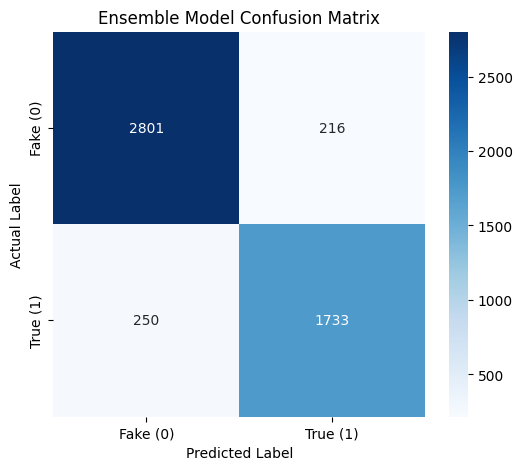

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Check if ensemble_pred is not empty before plotting
if ensemble_pred.size > 0:
    cm = confusion_matrix(y_test, ensemble_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fake (0)', 'True (1)'],
                yticklabels=['Fake (0)', 'True (1)'])
    plt.title('Ensemble Model Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
else:
    print("Cannot create confusion matrix: Ensemble predictions are empty.")

In [15]:
#Saving models for quick ensemble in the future

import os

# Ensure lstm_models is available
if 'lstm_models' in locals() and lstm_models:
    print("Saving individual LSTM models...")
    for name, model_obj in lstm_models.items():
        model_save_path = os.path.join(OUTPUT_DIR, f'{name}_complete_model.keras')
        model_obj.save(model_save_path)
        print(f"Saved {name} model to {model_save_path}")
else:
    print("No LSTM models found to save.")


Saving individual LSTM models...
Saved lstm64 model to /content/drive/MyDrive/Colab Notebooks/BDP - Project/Results/lstm64_complete_model.keras
Saved lstm128 model to /content/drive/MyDrive/Colab Notebooks/BDP - Project/Results/lstm128_complete_model.keras
Saved lstm256 model to /content/drive/MyDrive/Colab Notebooks/BDP - Project/Results/lstm256_complete_model.keras
